In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

Функции операторов  
- принимают параметры сетки и размерность задачи
- возвращают двумерный numpy массив

In [3]:
def second_derivative_operator(size, dx):
  matrix = np.eye(size)
  i,j=np.indices(matrix.shape)
  matrix[i==j]=-2
  matrix[i==j-1]=1
  matrix[i==j+1]=1
  matrix=matrix/dx/dx
  return matrix

In [4]:
def full_operator(size, dt, dx, g, H):
  return np.eye(size)-g*H*dt*second_derivative_operator(size,dx)

Функции методов,
- принимают начальную точку, матрицу, правую часть и число итераций
- возвращают numpy массив err_log, в котором на i-м месте лежат два-нормы ошибки на i-м шаге алгоритма

In [35]:
def sg_method(start_point, matrix, right_part, iter_number, er=1E-16):
  size = len(start_point)
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size

  real_answer = np.linalg.inv(matrix)@right_part

  err_log = np.zeros(iter_number)
  A=matrix
  b=right_part
  x=start_point
  r=b-A@x
  p=r

  for i in range(iter_number):
    Ap=A@p
    alpha=(r@r)/((Ap)@p)
    xnew=x+alpha*p
    rnew=r-alpha*Ap
    beta=(rnew@rnew)/(r@r)
    p=rnew+beta*p
    r=rnew

 #   if(r@r<er):
 #     break
    err_log[i]=np.linalg.norm(xnew-x,2)
    x=xnew

  return err_log

In [6]:
from math import sqrt
#q=(\sqrt(mu)-1)/(\sqrt(mu)+1) - скорость сходимости метода
def sg_theoretical_method(start_point, matrix, right_part, iter_number, mu):
  real_answer = np.linalg.inv(matrix)@right_part
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size
  q = (sqrt(mu)-1)/(sqrt(mu)+1)
  err_log = np.zeros(iter_number)

  #Сделаем одну настоящую итерацию чтобы узнать ||x_1-x_0||
  A=matrix
  b=right_part
  x=start_point
  r=b-A@x
  p=r


  Ap=A@p
  alpha=(r@r)/((Ap)@p)
  xnew=x+alpha*p
  rnew=r-alpha*Ap

  err_log[0] = np.linalg.norm(x-start_point,2)

  for i in range(1,iter_number):
    err_log[i]=q*err_log[i-1]

  return err_log


In [7]:
def jacobi_method(start_point, matrix, right_part, iter_number):
  size = len(start_point)
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size

  real_answer = np.linalg.inv(matrix)@right_part

  err_log = np.zeros(iter_number)

  D    = matrix*np.eye(size)
  LpU  = matrix-D

  Dinv=D
  i,j=np.indices(Dinv.shape)
  Dinv[i==j]=1/Dinv[i==j]

  x=start_point

  for i in range(iter_number):
    xnew=(right_part-(LpU)@x)@Dinv
    err_log[i]=np.linalg.norm(xnew-x,2)
    x=xnew

  return err_log

In [36]:
#delta - параметр для рассчета скорости сходимости, delta = g*H*dt/dx/dx
def jacobi_theor_method(start_point, matrix, right_part, iter_number, delta):
  real_answer = np.linalg.inv(matrix)@right_part
  assert np.shape(matrix)[0] == size
  assert np.shape(matrix)[0] == np.shape(matrix)[1]
  assert len(right_part) == size
  q = delta/(1-2*delta) #скорость сходимости
  err_log = np.zeros(iter_number)
  print("q={}".format(q))

  #Сделаем одну настоящую итерацию чтобы узнать ||x_1-x_0||
  D    = matrix*np.eye(size)
  LpU  = matrix-D

  Dinv=D
  i,j=np.indices(Dinv.shape)
  Dinv[i==j]=1/Dinv[i==j]

  x=start_point
  xnew=(right_part-(LpU)@x)@Dinv
  err_log[0]=np.linalg.norm(xnew-x,2)

  for i in range(1,iter_number):
    err_log[i]=q*err_log[i-1]

  return err_log

Функция отрисовки логов
- принимает в себя массив логов одинакового размера, параметры сетки, флаг для записи в директорию, флаг для логарифмирования, начальную и конечную точки сетки
- рисует пнг файл со сходимостями в директории

In [37]:
def logs_draw(logs, labels, dt, dx, method_step, write_flag, log_flag, start, end):
  for i in range(len(logs)):
    log=logs[i]
 #   mean_speed = np.mean(log[:-1]/log[1:])
    plt.plot(range(len(log[start:end])), log[start:end], label=labels[i])

  plt.title("dt = " + str(dt) + " dx = " + str(dx))
  plt.xlabel("iteration number")
  if(log_flag == 0):
    plt.ylabel(r"$||x_{k+1}-x_{k}||^2$")
  if(log_flag == 1):
    plt.ylabel(r"$\log||x_{k+1}-x_{k}||^2$")
    plt.yscale('log')


  #getting time
  from datetime import datetime
  now = datetime.now()
  current_time = now.strftime("%H:%M:%S")

  plt.legend()
  if (write_flag == 1):
    filename = "comparison test " + str(current_time)+" dt = " + str(dt) + " dx = " + str(dx) + "step = " + str(method_step)+".png"
    plt.savefig(filename)

Функция основного теста :
- Вход это размер матрицы,шаг по времени, шаг по пространству, шаг по времени, шаг итерационного процесса, количество итераций, начальную точку, флаги для отрисовки, диапазоны отрисовки
- На выходе рисует (в директорию если поднят соответствующий флаг) картинки сходимости

In [38]:
def methods_test(method_step, start_point, right_part, size=100, dt=100, dx=10000, iter_number = 10000, write_flag = 0, log_flag = 0, start=0, end = 1000, g=10, H=1000 ):
  matrix = full_operator(size,dt,dx,g,H)
#  mu = (1+4*g*H*dt/dx/dx)/(1-4*g*H*dt/dx/dx) # Число обусловленности
  sg_log = sg_method(start_point, matrix, right_part, iter_number)
#  sg_theor_log = sg_theoretical_method(start_point, matrix, right_part, iter_number, mu)
  jacobi_log = jacobi_method(start_point, matrix,right_part, iter_number)
  jacobi_theor_log = jacobi_theor_method(start_point, matrix, right_part, iter_number, delta = g*H*dt/dx/dx)
  labels=["conjudate","jacobi","jacobi_theor"]
  logs = [sg_log, jacobi_log, jacobi_theor_log]
  logs_draw(logs, labels, dt, dx, method_step, write_flag, log_flag, start, end)

In [39]:
size = 3000

q=0.010204081632653062


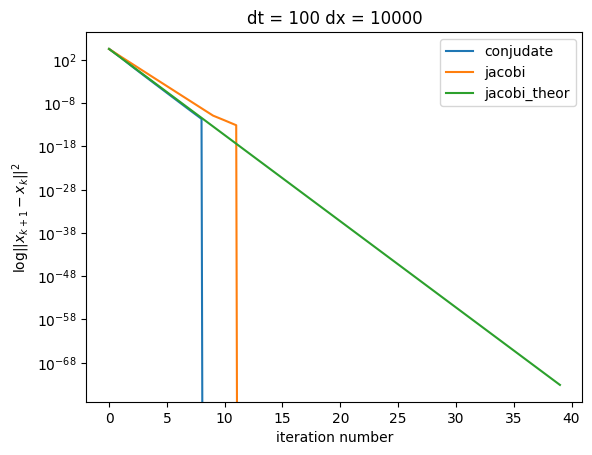

In [40]:
methods_test(method_step = 1, start_point = np.zeros(size), right_part = np.random.uniform(0.1, 1000, size), iter_number=40,write_flag = 0, log_flag = 1, end = 40, size = size)

In [13]:
matrix = full_operator(3,0.1,0.1,10,1000)